<a href="https://colab.research.google.com/github/ClaudeCoulombe/VIARENA/blob/master/Labos/Lab-Annotation_Images/Annotation_Images-Colab.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Rappel - Fonctionnement d'un carnet web iPython

* Pour exécuter le code contenu dans une cellule d'un carnet iPython, cliquez dans la cellule et faites (⇧↵, shift-enter) 
* Le code d'un carnet iPython s'exécute séquentiellement de haut en bas de la page. Souvent, l'importation d'une bibliothèque Python ou l'initialisation d'une variable est préalable à l'exécution d'une cellule située plus bas. Il est donc recommandé d'exécuter les cellules en séquence. Enfin, méfiez-vous des retours en arrière qui peuvent réinitialiser certaines variables.

# Droits d'auteur et inspiration:

Ce laboratoire est basé sur la première partie du tutoriel officiel de Google sur le module de détection d'objet de TensorFlow (Object Detection API). Il contient un outil d'annotation simple qui fonctionne dans Google Colab.

# Annotation d'images

## Annotation de photos de saumons de la passe migratoire de Matane en Gaspésie 


La passe migratoire de Matane en Gaspésie est le lieu par excellence pour observer les saumons qui remontent la rivière Matane<sup>1</sup> en saison de reproduction. En période touristique, un animateur dispense des informations sur la biologie du saumon de l'Atlantique. Nous en profitons pour remercier les responsables du <a href="https://www.rivierematane.com/observation-du-saumon.html" target='_blank'>Centre d'observation de la montée du saumon - Matane</a> pour le prêt de ces extraordinaires photos de saumons.
<hr/>
<sup>1</sup> On utilise le terme montaison

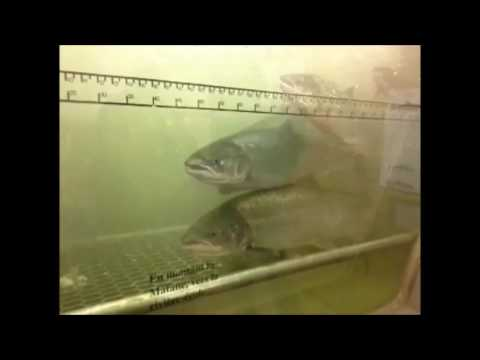

In [1]:
# Youtube - Passe migratoire de saumons à Matane
from IPython.display import Audio,Image, YouTubeVideo
id='j0YRc4Bqfoc'
YouTubeVideo(id=id,start=0,width=600,height=300,hl='fr',cc_lang_pref='fr',iv_load_policy=1)

## Importation des outils et des modèles de TensorFlow

In [2]:
import os
import pathlib

# Cloner le référentiel de modèles de TensorFlow 
# si ce n'est pas déjà fait
if "models" in pathlib.Path.cwd().parts:
    while "models" in pathlib.Path.cwd().parts:
        os.chdir('..')
elif not pathlib.Path('models').exists():
    !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2715, done.
remote: Counting objects: 100% (2715/2715), done.
remote: Compressing objects: 100% (2257/2257), done.
remote: Total 2715 (delta 686), reused 1241 (delta 424), pack-reused 0
Receiving objects: 100% (2715/2715), 32.70 MiB | 10.83 MiB/s, done.
Resolving deltas: 100% (686/686), done.
Updating files: 100% (2505/2505), done.


In [ ]:
# Installation du module TensorFlow de détection d'objets
# (TensoFlow Object Detection API) qui contient un outil 
# d'annotation simple.
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

**Note: Quelques erreurs sans conséquence peuvent s'afficher ci-dessus.** 

# Utilitaires

Remplacement de la fonction `colab_util.py`

In [63]:
!rm models/research/object_detection/utils/colab_util.py

In [64]:
!wget "https://github.com/ClaudeCoulombe/VIARENA/blob/master/Labos/Lab-Annotation_Images/colab_util.py?raw=True" -O models/research/object_detection/utils/colab_util.py


--2021-06-21 22:39:46--  https://github.com/ClaudeCoulombe/VIARENA/blob/master/Labos/Lab-Annotation_Images/colab_util.py?raw=True
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/ClaudeCoulombe/VIARENA/raw/master/Labos/Lab-Annotation_Images/colab_util.py [following]
--2021-06-21 22:39:47--  https://github.com/ClaudeCoulombe/VIARENA/raw/master/Labos/Lab-Annotation_Images/colab_util.py
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ClaudeCoulombe/VIARENA/master/Labos/Lab-Annotation_Images/colab_util.py [following]
--2021-06-21 22:39:47--  https://raw.githubusercontent.com/ClaudeCoulombe/VIARENA/master/Labos/Lab-Annotation_Images/colab_util.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.19

In [65]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline
print("Les utilitaires de l'outil d'annotation sont installés.")

Les utilitaires de l'outil d'annotation sont installés.


In [66]:
# Fonction qui lit une image et la 
# mémorise dans un tableau NumPy
def load_image_into_numpy_array(path):
    """Load an image from file into a numpy array.
    
    Puts image into numpy array to feed into tensorflow graph.
    Note that by convention we put it into a numpy array with shape
    (height, width, channels), where channels=3 for RGB.
    
    Args:
        path: a file path.

    Returns:
        uint8 numpy array with shape (img_height, img_width, 3)
    """
    img_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(img_data))
    (im_width, im_height) = image.size
    
    return np.array(image.getdata()).reshape((im_height, im_width, 3)).astype(np.uint8)

# Fonction qui affiche les cadres avec les classes détectés
def plot_detections(image_np,
                    boxes,
                    classes,
                    scores,
                    category_index,
                    figsize=(12, 16),
                    image_name=None):
    """Wrapper function to visualize detections.
    
    Args:
        image_np: uint8 numpy array with shape (img_height, img_width, 3)
        boxes: a numpy array of shape [N, 4]
        classes: a numpy array of shape [N]. Note that class indices are 1-based,
          and match the keys in the label map.
        scores: a numpy array of shape [N] or None.  If scores=None, then
          this function assumes that the boxes to be plotted are groundtruth
          boxes and plot all boxes as black with no classes or scores.
        category_index: a dict containing category dictionaries (each holding
          category index `id` and category name `name`) keyed by category indices.
        figsize: size for the figure.
        image_name: a name for the image file.
      """
    
    image_np_with_annotations = image_np.copy()
    viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_annotations,
        boxes,
        classes,
        scores,
        category_index,
        use_normalized_coordinates=True,
        min_score_thresh=0.8)
    if image_name:
        plt.imsave(image_name, image_np_with_annotations)
    else:
        plt.imshow(image_np_with_annotations)

print("Quelques utilitaires supplémentaires pour l'outil d'annotation sont installés.")

Quelques utilitaires supplémentaires pour l'outil d'annotation sont installés.


# Acquisition des données
## Téléchargement de photos de saumons de la passe migratoire de Matane

Vous allez télécharger cinq (5) photos de saumons qui sont stockées sur le site GitHub du cours VIARENA. Cette utilisation de la fonction Unix / Linux `wget` pour télécharger des données stockées sur GitHub vous sera utile ultérieurement.

**Note**: L'outil d'annotation impose une limite supérieure de 600 pixels pour la hauteur des images. Au besoin, vous devrez refomater vos images pour tenir compte de cette contrainte.

In [67]:
# Création d'un répertoire pour stocker les photos
!mkdir Photos_Saumons
# Téléchargement des photos
!wget "https://github.com/ClaudeCoulombe/VIARENA/blob/master/Labos/Lab-Annotation_Images/Photos_Saumons/saumon_Matane-1.jpg?raw=True" -O Photos_Saumons/saumon_Matane-1.jpg
!wget "https://github.com/ClaudeCoulombe/VIARENA/blob/master/Labos/Lab-Annotation_Images/Photos_Saumons/saumon_Matane-2.jpg?raw=True" -O Photos_Saumons/saumon_Matane-2.jpg
!wget "https://github.com/ClaudeCoulombe/VIARENA/blob/master/Labos/Lab-Annotation_Images/Photos_Saumons/saumon_Matane-3.jpg?raw=True" -O Photos_Saumons/saumon_Matane-3.jpg
!wget "https://github.com/ClaudeCoulombe/VIARENA/blob/master/Labos/Lab-Annotation_Images/Photos_Saumons/saumon_Matane-4.jpg?raw=True" -O Photos_Saumons/saumon_Matane-4.jpg
!wget "https://github.com/ClaudeCoulombe/VIARENA/blob/master/Labos/Lab-Annotation_Images/Photos_Saumons/saumon_Matane-5.jpg?raw=True" -O Photos_Saumons/saumon_Matane-5.jpg

mkdir: cannot create directory ‘Photos_Saumons’: File exists
--2021-06-21 22:39:54--  https://github.com/ClaudeCoulombe/VIARENA/blob/master/Labos/Lab-Annotation_Images/Photos_Saumons/saumon_Matane-1.jpg?raw=True
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/ClaudeCoulombe/VIARENA/raw/master/Labos/Lab-Annotation_Images/Photos_Saumons/saumon_Matane-1.jpg [following]
--2021-06-21 22:39:54--  https://github.com/ClaudeCoulombe/VIARENA/raw/master/Labos/Lab-Annotation_Images/Photos_Saumons/saumon_Matane-1.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ClaudeCoulombe/VIARENA/master/Labos/Lab-Annotation_Images/Photos_Saumons/saumon_Matane-1.jpg [following]
--2021-06-21 22:39:54--  https://raw.githubusercontent.com/ClaudeCoulombe/VIARENA/master/Labo

## Lecture et affichage des images


In [68]:
# Lecture des images et chargement dans un tableau NumPy
train_image_dir = 'Photos_Saumons/'
train_images_np = []
# Répéter pour les 5 images
for i in range(1, 6):
  # Construction d'un chemin d'accès à chaque image
  image_path = os.path.join(train_image_dir, 'saumon_Matane-' + str(i) + '.jpg')
  # Affichage du chemin d'accès
  print(image_path)
  # Lecture de chaque image et stockage dans un tableau NumPy
  train_images_np.append(load_image_into_numpy_array(image_path))

print("\nLecture et chargement des images terminés.")

Photos_Saumons/saumon_Matane-1.jpg
Photos_Saumons/saumon_Matane-2.jpg
Photos_Saumons/saumon_Matane-3.jpg
Photos_Saumons/saumon_Matane-4.jpg
Photos_Saumons/saumon_Matane-5.jpg

Lecture et chargement des images terminés.


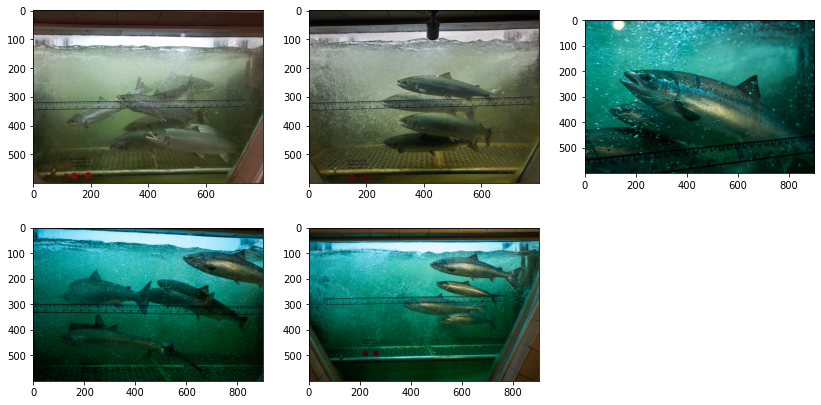

In [69]:
# Affichage des images dans un grille 
# plt.figure(figsize=(20,15))
plt.figure(figsize=(14,7))
for idx, train_image_np in enumerate(train_images_np):
    plt.subplot(2, 3, idx+1)
    plt.imshow(train_image_np)
plt.show()

# Annotation des images avec des cadres<sup>1</sup>

Vous allez annoter des images de saumons pour préparer les données pour la détection d'objets.

Pour cela, vous allez dessiner un rectangle pour encadrer et isoler un saumon situé au premier plan dans une image. 

<hr/>
<sup>1</sup>En français on dit tout simplement «cadres» ou parfois «boîtes englobantes». En anglais «bounding boxes».

In [70]:
gt_boxes = []
colab_utils.annotate(train_images_np, box_storage_pointer=gt_boxes)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

'--boxes array populated--'

<IPython.core.display.Javascript object>

## Fusion des annotations et des étiquettes de classe

La dernière étape de préparation des données consiste en la fusion des annotations avec les étiquettes de classe. 

### Définition d'un dictionnaire des classes-cibles

Pour simplifier nous avons supposé deux classes-cibles «saumon» et «pas_saumon» dans ce laboratoire, bien qu'il devrait être facile de l'étendre pour gérer plusieurs classes.

In [71]:
# Nous avons deux classes-cibles: saumon = 1 et pas_saumon = 0
id_classe_pas_saumon = 0
id_classe_saumon = 1
num_classes = 2

# Note: les clés du dictionnaire 'id' et 'name' sont attendues par le module de visualisation 
dict_classes_cibles = { 0: {'id': id_classe_pas_saumon, 'name':'pas_saumon'},
                        1: {'id': id_classe_saumon, 'name':'saumon'}
                      }

### Attribution des classes-cibles aux images

Vous allez inspecter manuellement les images pour confirmer la classe pour chacune, notez que :

* 0 est pour un cadre ne contenant pas un saumon
* 1 est pour un cadre contenant un saumon 

**Attention!** Pour les fins de la démonstration vous allez délibérément introduire un exemple de la classe 'pas_saumon' comme dernière donnée annotée. 

**Note:** un outil plus complet d'annotation devrait permettre le choix de la classe au moment de la mise en place du cadre autour de l'objet à identifier

In [72]:
# Vous allez inspecter manuellement les images pour confirmer la classe pour chacune, notez que :
# 0 est pour un cadre ne contenant pas un saumon
# 1 est pour un cadre contenant un saumon 
#
# Note: un outil plus complet d'annotation devrait permettre le choix de la classe 
# au moment de la mise en place du cadre

vraies_classes_cibles = [
  1*np.ones(shape=(1), dtype=np.int32),
  1*np.ones(shape=(1), dtype=np.int32),
  1*np.ones(shape=(1), dtype=np.int32),
  1*np.ones(shape=(1), dtype=np.int32),
  # Ici, vous allez introduire une étiquette 'pas_saumon' 
  # soit 0, pour constater le résultat à l'affichage
  0*np.ones(shape=(1), dtype=np.int32)    
]

# Donner aux cadres un score de 100 %
scores_bidons = np.array([1.0], dtype=np.float32)  

print("Attribution des classes-cibles")

Attribution des classes-cibles


## Visualisation des images annotées

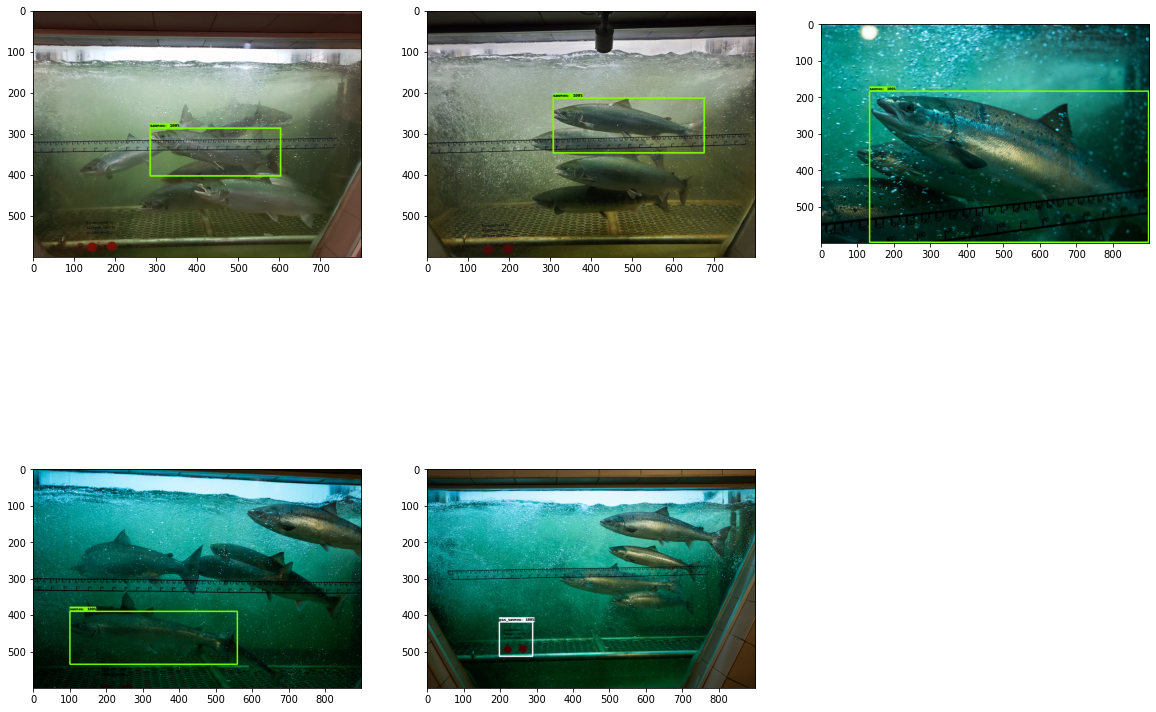

In [73]:
plt.figure(figsize=(20, 15))
for idx in range(5):
    plt.subplot(2, 3, idx+1)
    plot_detections(
        train_images_np[idx],
        gt_boxes[idx],
        vraies_classes_cibles[idx],
        scores_bidons, 
        dict_classes_cibles)
plt.show()

### **Note:** Il se peut que vous obteniez parfois des erreurs car cet outil d'annotation n'est pas robuste.
### Vous n'avez qu'à reprendre l'annotation.